In [2]:
using LightGraphs, Distributions, DataFrames, ProgressMeter, RCall

In [3]:
srand(20130810)

MersenneTwister(UInt32[0x01332bfa], Base.dSFMT.DSFMT_state(Int32[-1772545288, 1073534108, 1077066014, 1072915095, -2146195133, 1072843413, 301764553, 1073404181, 750472136, 1073628106  …  -1491411563, 1073194977, 716119449, 1072893711, 1632331784, 758890923, 1433693833, -13012230, 382, 0]), [1.00784, 1.72551, 1.53682, 1.64715, 1.48015, 1.76568, 1.50925, 1.75842, 1.99756, 1.3348  …  1.56334, 1.69415, 1.7659, 1.40375, 1.59055, 1.12554, 1.6931, 1.12657, 1.73362, 1.92055], 382)

The decision to invest in an innovation is based on its perceived usefulness (*utility*). If the utility exceeds the barrier to adoption (measured by a threshold), the individual adopts the innovation.

The utility $u_i$ for the individual $i$ is a combination of personal benefit ($p_i$), direct influence from an individuals peer group and influence from society in general. Hence,

$$
u_i(t) = \alpha_ip_i + \beta_is_i(t) + \gamma_im(t)
$$

In this equation, $s_i$ measures the impact of adoption from the peer group of an individual and $m$ measures the mainstream norm (average adoption among the entire network). Since each individual can attach differing weights to each of these three parameters, i.e., personal benefit, peer group influence and mainstream norm, we can vary the weights $\alpha_i, \beta_i, \gamma_i$ such that $\alpha_i + \beta_i + \gamma_i = 1$.

The problem description is as follows.

> Given a particular network, initial set of adopters and parameter
values $(\alpha, \beta, \gamma, p, \theta)$, we ask whether or not the innovation succeeds, that is, do most individuals
adopt the innovation. In each case, 5% of
the nodes are chosen as seed nodes at random and are set to 1, with the rest initialised at 0. The detailed structure of
the network is randomised at each set of parameter values. In order to look at the influence of
the parameters on the expected uptake, this calculation is repeated 100 times over a range of parameter
values and plotted in the $\beta$, $\gamma$ parameter space, with $0 \leq \beta \leq 1$, $0 \leq \gamma \leq 1$ and $\alpha = 1 - \beta - \gamma$. Our dependent variable is the average number of individuals adopted at the end of a predetermined set of time steps.


In [4]:
mutable struct Network
    G::LightGraphs.SimpleGraphs.SimpleGraph{Int}
    node_status::BitVector
end

In [11]:
function seed!(N::Network)
    seed_set = sample(vertices(N.G), floor(Int, 0.05 * nv(N.G)))
    N.node_status[seed_set] = true
    
    return nothing
end

seed! (generic function with 1 method)

In [6]:
function peer_influence(N::Network, node::Int)
    return sum([N.node_status[nbr] for nbr in neighbors(N.G, node)])/length(neighbors(N.G, node))
end

peer_influence (generic function with 1 method)

In [7]:
function mainstream_norm(N::Network)
    return sum(N.node_status)/nv(N.G)
end

mainstream_norm (generic function with 1 method)

In [8]:
function evolve!(N::Network, beta::Float64, gamma::Float64; p = 0.5, theta = 0.25)
    for node in shuffle(vertices(N.G))
        if N.node_status[node] == false
            s, m = peer_influence(N, node), mainstream_norm(N)
            if (beta * s + gamma * m + (1 - beta - gamma) * p) > theta
                N.node_status[node] = true
            end
        end
    end
    
    return nothing
end

evolve! (generic function with 1 method)

## Simulation on Erdos-Renyi random graphs

In [22]:
function simulate_er(n::Int, p::Float64; T = 35, n_realizations = 100)
    parameter_space = [(beta, gamma) for beta in linspace(0, 1, 10),
                                         gamma in linspace(0, 1, 10)]
    
    output = DataFrame(r = Int[], avg_degree = Float64[], beta = Float64[], gamma = Float64[], avg_engaged = Float64[])
    
    @showprogress 1 "Simulating..." for (beta, gamma) in parameter_space
        for r in 1:n_realizations
            g = erdos_renyi(n, p)
            ns = falses(nv(g))
            N = Network(g, ns)
            
            seed!(N)

            for t in 1:T
                evolve!(N, beta, gamma)
            end
            avg_frac_engaged = sum(N.node_status)/nv(N.G)

            push!(output, [r, mean(degree(g)), beta, gamma, avg_frac_engaged])
        end
    end
    
    return output
end 

simulate_er (generic function with 2 methods)

In [23]:
results = simulate_er(500, 0.01)

Simulating...100%|██████████████████████████████████████| Time: 0:00:25


,r,avg_degree,beta,gamma,avg_engaged
1,1,5.064,0.0,0.0,0.994
2,2,4.876,0.0,0.0,0.994
3,3,5.028,0.0,0.0,0.994
4,4,4.988,0.0,0.0,0.99
5,5,4.82,0.0,0.0,0.994
6,6,4.872,0.0,0.0,0.998
7,7,5.164,0.0,0.0,0.992
8,8,5.192,0.0,0.0,0.998
9,9,5.152,0.0,0.0,0.994
10,10,5.104,0.0,0.0,0.996


In [25]:
@rput results

,r,avg_degree,beta,gamma,avg_engaged
1,1,5.064,0.0,0.0,0.994
2,2,4.876,0.0,0.0,0.994
3,3,5.028,0.0,0.0,0.994
4,4,4.988,0.0,0.0,0.99
5,5,4.82,0.0,0.0,0.994
6,6,4.872,0.0,0.0,0.998
7,7,5.164,0.0,0.0,0.992
8,8,5.192,0.0,0.0,0.998
9,9,5.152,0.0,0.0,0.994
10,10,5.104,0.0,0.0,0.996


In [28]:
R"""
library(tidyverse)

results_summary <- results %>% group_by(beta, gamma) %>% summarize(Degree = mean(avg_degree),
                                                                   Avg_Uptake = mean(avg_engaged),
                                                                   Var_Uptake = var(avg_engaged)) 


"""

RCall.RObject{RCall.VecSxp}
# A tibble: 100 x 5
# Groups:   beta [?]
    beta gamma Degree Avg_Uptake Var_Uptake
   <dbl> <dbl>  <dbl>      <dbl>      <dbl>
 1    0. 0.      4.97     0.994  0.0000116 
 2    0. 0.111   4.97     0.994  0.0000134 
 3    0. 0.222   4.97     0.994  0.0000112 
 4    0. 0.333   5.01     0.994  0.0000108 
 5    0. 0.444   4.98     0.993  0.0000152 
 6    0. 0.556   4.99     0.0491 0.00000157
 7    0. 0.667   5.01     0.0491 0.00000180
 8    0. 0.778   4.99     0.0490 0.00000198
 9    0. 0.889   4.99     0.0490 0.00000198
10    0. 1.00    4.97     0.0487 0.00000223
# ... with 90 more rows


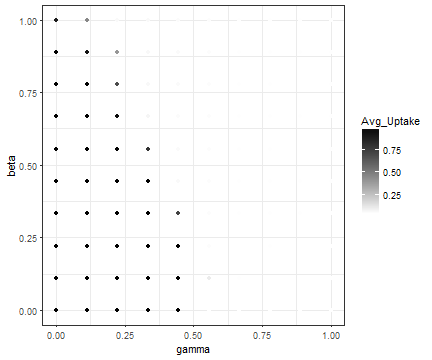

RCall.RObject{RCall.VecSxp}


In [31]:
R"""
ggplot(data = results_summary, aes(x = gamma, y = beta)) +
    geom_point(aes(color = Avg_Uptake)) +
    scale_color_gradient(low = "white", high = "black") +
    theme_bw()

"""

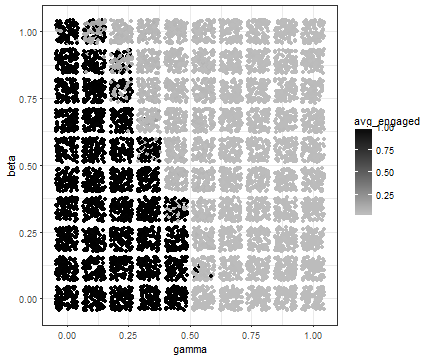

RCall.RObject{RCall.VecSxp}


In [35]:
R"""
ggplot(data = results, aes(x = gamma, y = beta)) + 
    geom_point(aes(color = avg_engaged), position = "jitter") +
    scale_color_gradient(low = "grey", high = "black") +
    theme_bw()

"""